--- 
    Autores: Carlos Francisco Orejuela Lluncor<carlos.f.olluncor@udc.es>; Hugo Varela Sanchéz
    Asignatura: Modelización Estadística de Datos de Alta Dimensión
    Curso: 2024/2025
---

# Análisis del suelo de sotobosques de pinos

Descripción de las variables del conjunto de datos:
* Contenido en ppm de diferentes elementos químicos en el suelo de una parcela: N, P, K, Ca, Mg, S, Al, Fe, Mn, Zn, Mo
* Baresoil (Categorica): Cubierta de suelo desnudo (Low, High). Representa la zona que carece de vegetación en una parcela.
* Humdepth: grosor de la capa de humus (cm).
* pH (Categorica): pH del suelo (Low, Med, High)

Objetivo principal de esta práctica:
* Agrupar las parcelas con aquellas con características similares (Clustering)

In [305]:
library(ggplot2)
library(patchwork)
library(psych)
library(repr)

In [259]:
# Cargamos los datos
load("vegetal.RData")
df_vegetal <- vegetal

In [260]:
# Un vistazo a la estructura
head(df_vegetal, 2)

,N,P,K,Ca,Mg,S,Al,Fe,Mn,Zn,Mo,Baresoil,Humdepth,pH
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
1,22.3,47.4,165.9,436.1,64.3,42.3,316.5,200.1,28.2,7.2,0.3,Low,1.5,Med
2,31.1,32.3,73.7,219.0,52.5,25.5,304.6,204.4,14.2,2.6,0.5,Low,1.8,High


---
### Análisis exploratorio

#### Variables cuantitativas:

In [261]:
# Creacion de tabla de estadisticos para variables numericas:

stats_summary <- function(df){
    # Estadisticos a tener en cuenta
    cols <- c('Min.', '1st Qu.', 'Median', 'Mean', '3rd Qu.', 'Max.', 'Sd')
    stats_table <- c()
    for (i in 1:ncol(df)){
        # Agregar el estadistico de la desv. estandar
        colstats <- c( as.vector(summary(df[, i])), sd(df[, i]) )
        stats_table <- rbind(stats_table, colstats)
    }
    # Formatear tabla de estadisticos 
    stats_table <- data.frame(stats_table, row.names = colnames(df))
    colnames(stats_table) <- cols
    stats_table <- round(stats_table, 2)
    return(stats_table)
}

df_numeric <- df_vegetal[, c(1:11, 13)]
stats_table <- stats_summary(df_numeric)
stats_table

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,Sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N,13.40,18.83,22.05,22.38,26.30,33.1,5.53
P,22.70,32.60,41.50,45.08,57.05,73.5,14.95
K,43.60,127.15,166.60,162.93,205.75,313.8,64.84
Ca,188.50,425.72,518.50,569.66,739.25,1169.7,243.58
Mg,25.70,60.90,75.05,87.46,108.70,209.1,41.01
S,14.90,29.42,36.25,37.19,43.60,60.2,11.67
Al,12.10,38.20,106.80,142.48,233.72,435.1,122.32
Fe,2.30,5.58,27.80,49.61,85.15,204.4,60.45
Mn,10.10,26.70,36.55,49.33,59.00,132.0,33.91


A través de la tabla de estadísticos de las propiedades cuantitativas sobre el suelo de los sotobosques de pinos en esta muestra se obtiene lo siguiente:
1. En promedio, el elemento químico con mayor concentración en ppm sobre el suelo de las parcelas es el Calcio (Ca). Asimismo, en media se obtuvo que existen parcelas que pueden variar con respecto al centroide en 243.58 ppm, siendo esta el elemento químico con mayor variabilidad. Esto es un indicador que en la muestra tomada de sotobosques de pinos se tienen unas con una concentración de Calcio muy baja como muy alta.

In [262]:
ppm_mean <- stats_table[, "Mean"]
names(ppm_mean) <- colnames(df_numeric)
# Buscar la posicion del elemento quimico con menor y mayor concentracion en ppm
max_ppm <- which.max(ppm_mean)
print("Mayor concentracion en ppm:"); print(ppm_mean[max_ppm])

[1] "Mayor concentracion en ppm:"
    Ca 
569.66 


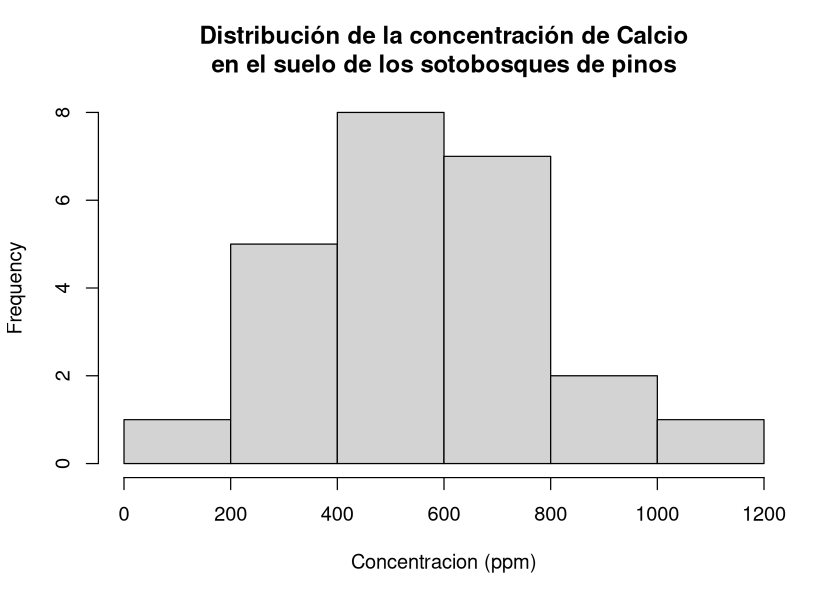

In [263]:
hist(df_numeric$Ca,
     xlab = "Concentracion (ppm)",
     main = "Distribución de la concentración de Calcio\nen el suelo de los sotobosques de pinos")

2. El Molidebno (Mo) es el caso opuesto del Calcio, porque es el elemento químico con menor concentración en ppm en el suelo de los sotobosques de pinos, así como el de menor variabilidad.

[1] "Menor concentracion en ppm:"
 Mo 
0.4 


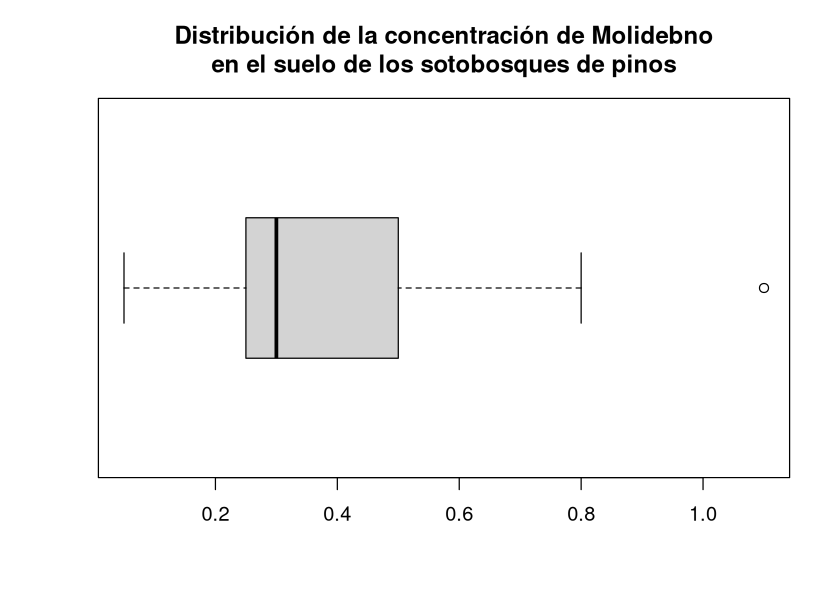

In [264]:
min_ppm <- which.min(ppm_mean)
print("Menor concentracion en ppm:"); print(ppm_mean[min_ppm])
# Distribucion
boxplot(df_numeric[, "Mo"],
        horizontal = T,
        main = "Distribución de la concentración de Molidebno\nen el suelo de los sotobosques de pinos")

In [265]:
# Se observa la presencia de un dato tipico en la muestra
outlier <- df_numeric[which.max(df_numeric$Mo), "Mo"]
sin_outlier <- df_numeric[df_numeric$Mo != outlier, "Mo"]
# Calcular en cuanto se increment la media de la concentracion de Molidebno en el suelo de las parcelas
pct <- round(stats_table["Mo", "Mean"]/mean(sin_outlier) - 1, 2)
cat("La media del Mo se incrementa en un", pct*100, "% (aprox.) debido a la presencia del outlier.")

La media del Mo se incrementa en un 10 % (aprox.) debido a la presencia del outlier.

3. El grosor de la capa de humus de esta muestra de sotobosques de pinos se encuentra entre 1 y 3 cm, aunque existe solo una observación cuyo valor para esta propiedad se encuentra más alejado de este rango.

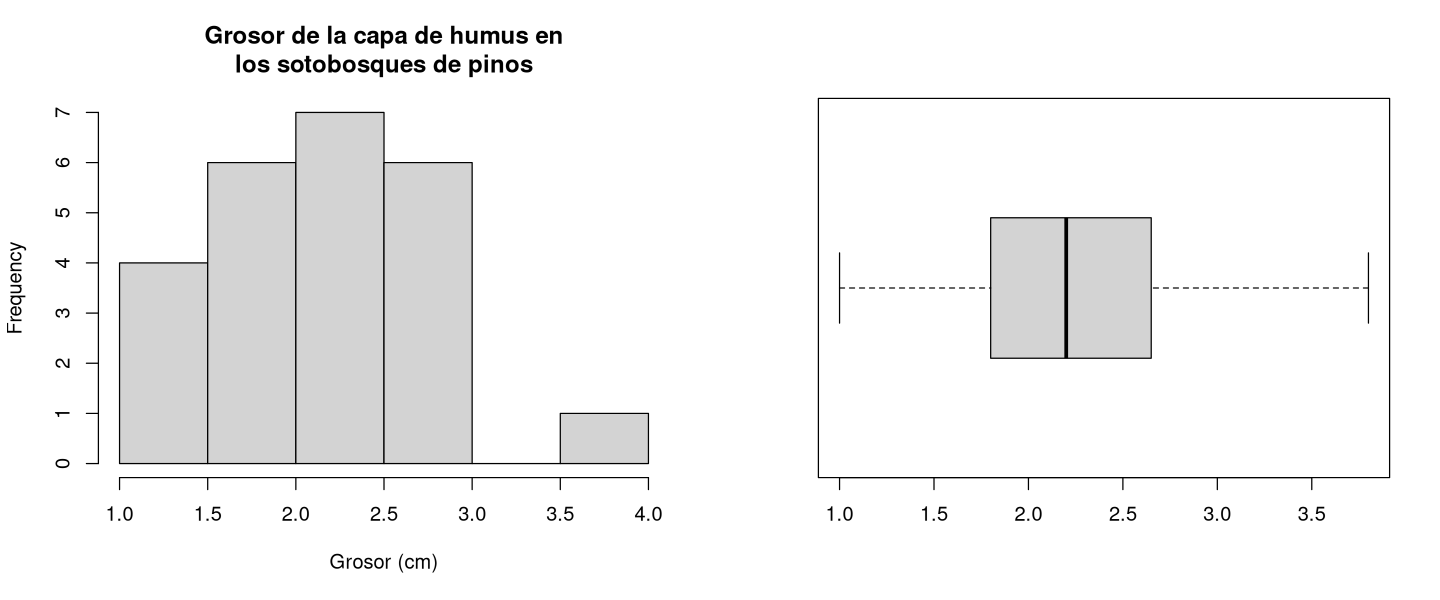

In [266]:
# Analizar el grosor de la capa de humus (cm)
options(repr.plot.width=12, repr.plot.height=5)
par(mfrow=c(1, 2))
hist(df_numeric$Humdepth, 
    xlab = "Grosor (cm)",
    main = "Grosor de la capa de humus en\nlos sotobosques de pinos")
boxplot(df_numeric$Humdepth, horizontal = T)

In [267]:
sum(df_numeric$Humdepth > 3)

[1] 1

4. Como se puede observar a través de la distribución del contenido medido en ppm de los diferentes elementos químicos:
   * El nitrógeno (N), Zinc (Zn) y Molidebno (Mo) son los que menos concentración tienen sobre el suelo de esta muestra de sotobosques de pinos.
   * Como se mencionó anteriormente, el Calcio (Ca) es con diferencia el elemento químico que mayor presencia tiene en suelo de estas 24 parcelas, siendo este superior a la mediana tanto del Potasio (K) como del Aluminio (Al), que son los otros 2 elementos químicos con mayor contenido en ppm que se pueden encontrar.
   * Por la asimetría de los boxplots del Calcio (Ca), Aluminio (Al) y Hierro (Fe), se observa que para esta muestra se han tomado tanto parcelas que tienen una gran concentración de estos elementos químicos sobre sus suelos, así como otras que cuentan con una cantidad más pequeña. Se tendría que analizar si existe alguna variable que cause que unas parcelas tengan un mayor contenido en ppm que otras sobre estos elemmentos.
   * Se tiene registro de datos atípicos tanto para el Magnesio (Mg), Manganeso (Mn), Zinc (Zn) y Molidebno (Mo). Y a través del análisis de los valores que toman para los elementos químicos que mayor concentración tienen sobre el suelo de una parcela se obtuvo que:
     * Aluminio: Las observaciones 22 y 23 son de aquellas parcelas con menor contenido tienen sobre este elemento; mientras que la 3 y 21 cuentan con una concentración mayor que el 50% de las datos, siendo esta primera (rowid 3) la parcela que mayor contenido de Aluminio en ppm tiene en la muestra.
     * Potasio: A excepción del dato atípico con rowid 22, se tiene que estas parcelas cuentan con un contenido de Potasio mayor a 166.6 ppm (Q2). 
     * Calcio: Cuentan con un contenido de Calcio mayor o igual a 518.5 ppm (Q2) aproximadamente (rowid 3).
     En un principio se esperaba que estos datos atípicos pertenezcan al grupo de parcelas con mayor concentración sobre estos elementos químicos. Sin embargo, este comportamiento no se pudo observar para el Aluminio.    

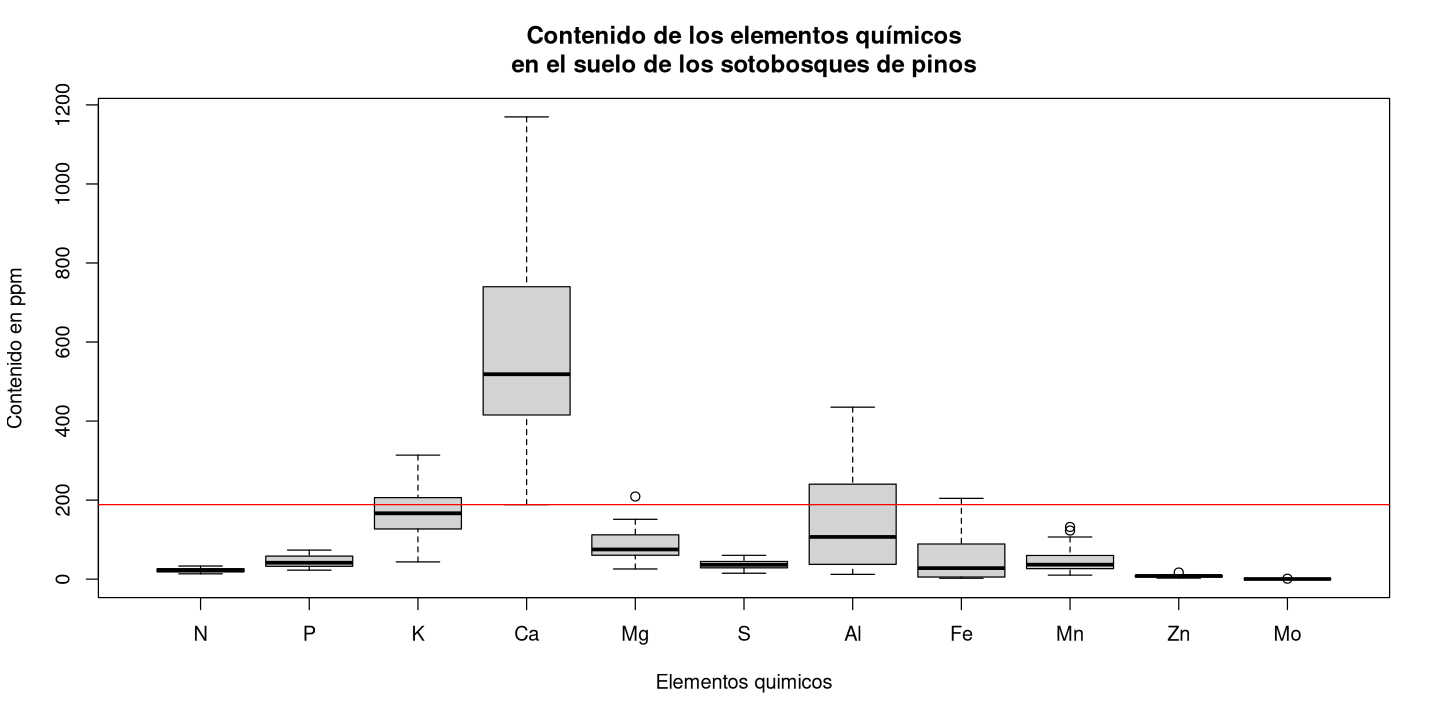

In [268]:
options(repr.plot.width=12, repr.plot.height=6)
boxplot(df_numeric[, 1:ncol(df_numeric) - 1],
       main = "Contenido de los elementos químicos\nen el suelo de los sotobosques de pinos",
       xlab = "Elementos quimicos", ylab = "Contenido en ppm")
abline(h=quantile(df_numeric$Ca, probs=c(0)), col = "red")

In [269]:
# Obtener los row ids de los datos atpicos
elementos <- c("Mg", "Mn", "Zn", "Mo")
outliers <- c()
for (i in 1:length(elementos)){
    data <- df_numeric[, elementos[i]]
    # Un dato se considera atipico si es > Q3 + 1.5*IQR | < Q1 - 1.5*IQR 
    cuartiles <- quantile(data, probs=c(0.25, 0.75))
    q1 <- cuartiles[1]; q3 <- cuartiles[2]
    IQR <- q3 - q1
    rowids <- which(data > q3 + IQR*1.5)
    outliers <- c(outliers, which(data > q3 + IQR*1.5))
    cat("Outliers para el", elementos[i], "->", rowids, "\n") 
}
table(outliers)

Outliers para el Mg -> 21 
Outliers para el Mn -> 22 23 
Outliers para el Zn -> 21 
Outliers para el Mo -> 3 


outliers
 3 21 22 23 
 1  2  1  1 

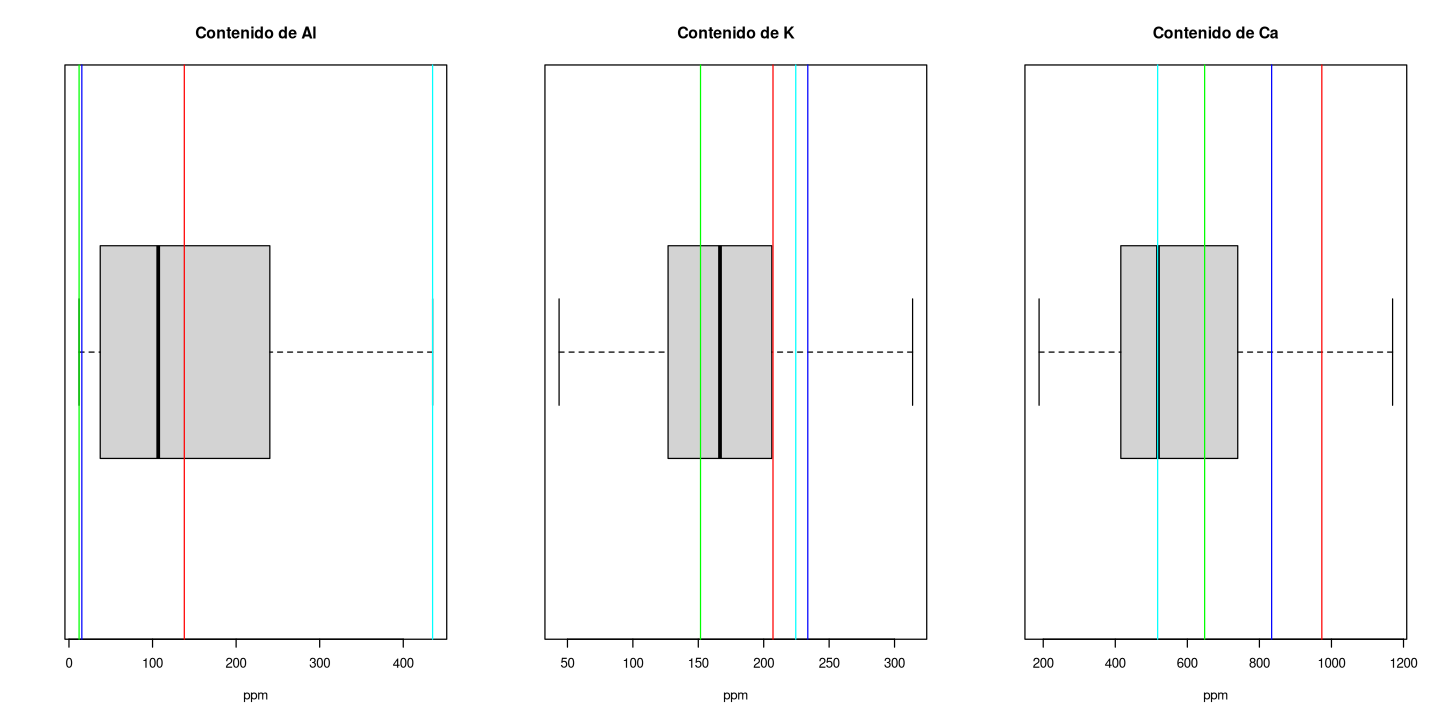

In [270]:
# Contenido en ppm de Aluminio, Potasio y Calcio de estos outliers
elementos <- c("Al", "K", "Ca")
par(mfrow=c(1, 3))
for (i in 1:length(elementos)){
    data <- df_numeric[, elementos[i]]
    title <- paste("Contenido de", elementos[i])
    boxplot(data, horizontal = T, main=title, xlab="ppm")
    abline( v=c(data[unique(outliers)]), col = c("red", "green", "blue", "cyan"))
}

Leyenda:
* red $\rightarrow$ 21
* green $\rightarrow$ 22
* blue $\rightarrow$ 23
* cyan $\rightarrow$ 3

---

#### Variables cualitativas:

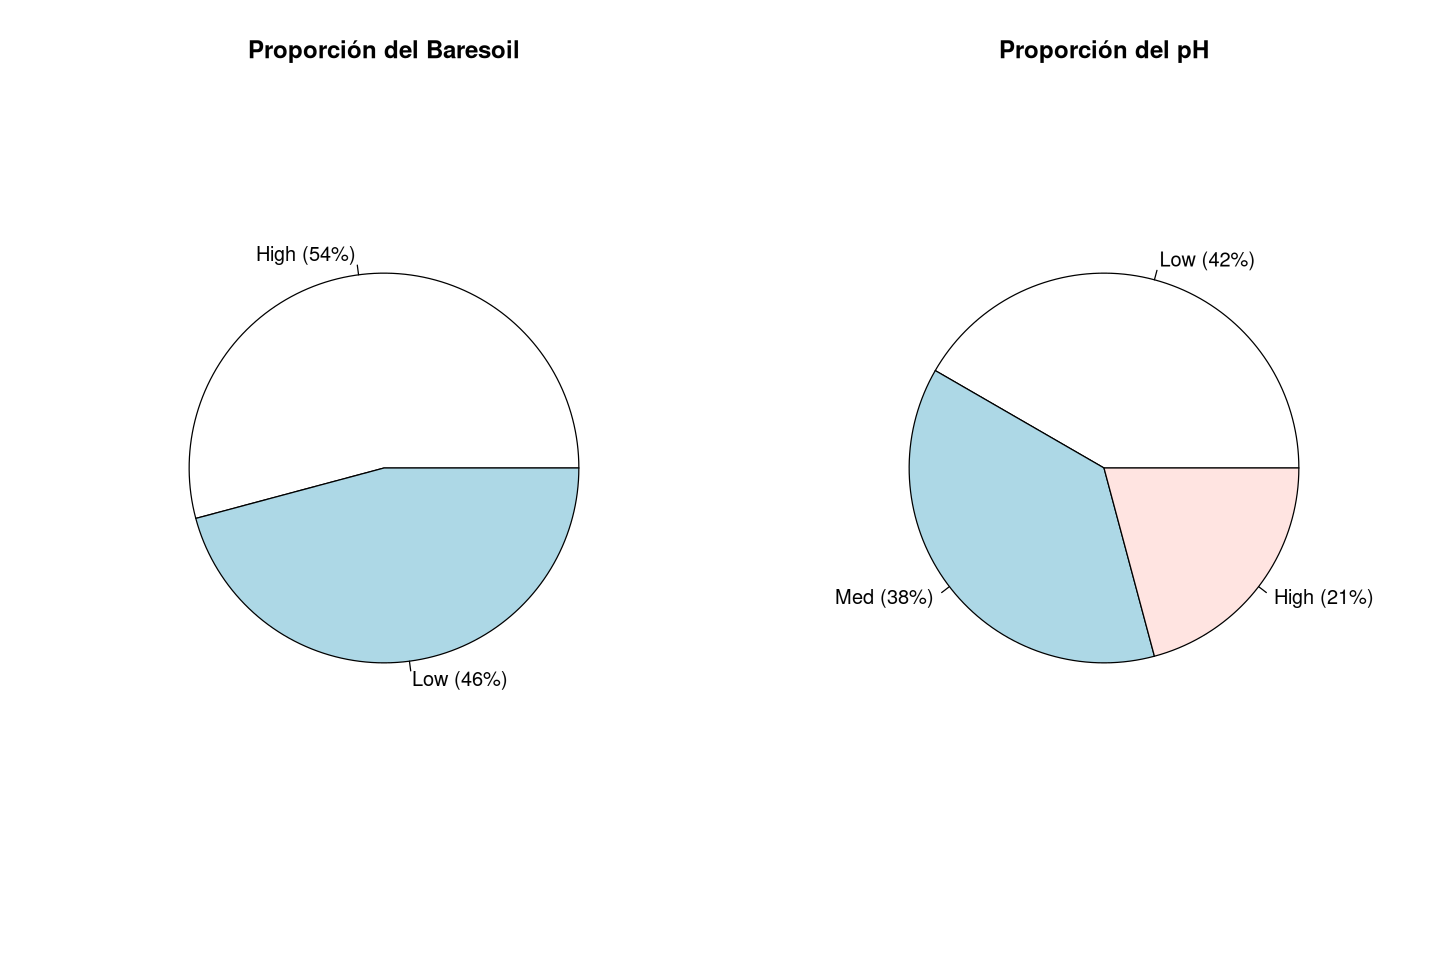

In [271]:
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow=c(1, 2))
category_vars <- c("Baresoil", "pH")
for (i in 1:length(category_vars)){
 data <- df_vegetal[, category_vars[i]]
 # Calcular la proporcion para nivel de la variable categorica
 prop <- round(table(data)/nrow(df_vegetal), 2)
 labels <- c()
 # Definir las etiquetas para el pie chart: category (x%)
 for (j in 1:length(unique(data))){
     labels <- c(labels, paste0( names(prop[j]), " (", prop[j]*100, "%)"))
 }
 pie(table(data), 
     labels=labels, 
     radius=1.3, 
     main=paste("Proporción del", category_vars[i]))   
}

De la muestra de sotobosques de pinos se tiene que de manera aproximadamente proporcional se recogieron datos de parcelas con un nivel de suelo desnudo (Baresoil) tanto alto y bajo. Asimismo, se observa que el 80% de los registros son de parcelas que no poseen un pH alto, y la diferencia entre los porcentajes de parcelas con un pH bajo y medio no es significativamente grande.

---

#### Análisis multivariante

En primer lugar, se procede a estudiar la matriz de correlación entre las variables cuantitativas. Pero como se tiene un númer elevado de variables resulta más apropiado solo seleccionar aquellos que posee un coeficiente de correlación de Pearson significativo para evitar graficar una matriz de correlación que sea compleja de entender.

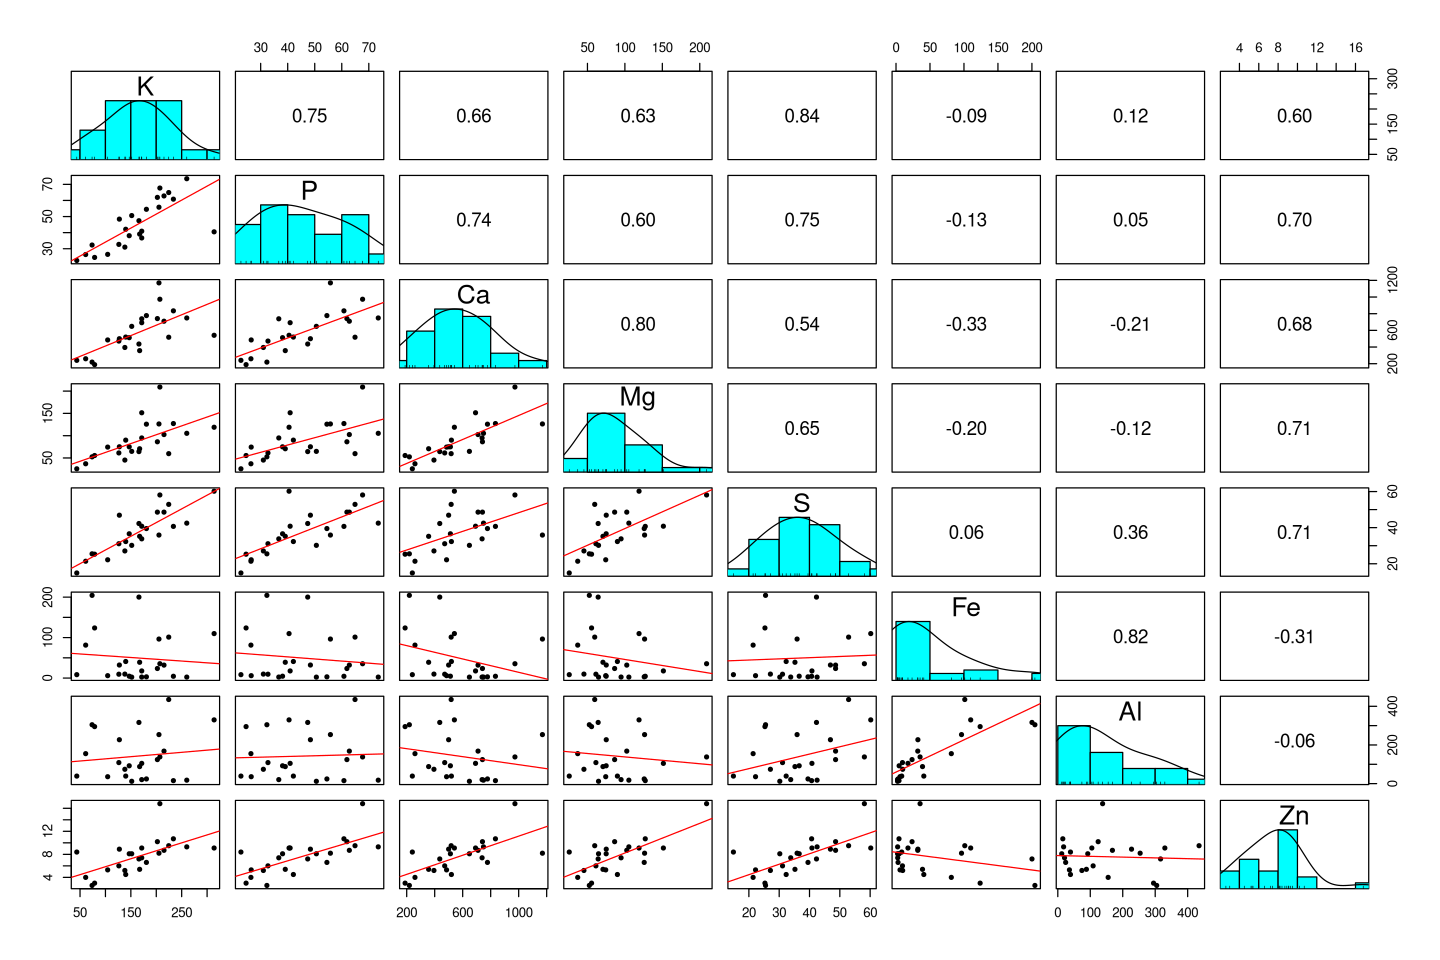

In [272]:
cor_matrix <- cor(df_numeric)
elementos <- c()
# Solo se recorre la triangular superior de la matriz de correlaciones.
for (row in 2:nrow(cor_matrix)){
    for (col in 1:(row - 1)){
        rho <- cor_matrix[row, col] # Coeficiente de correlacion lineal de Pearson
        if (rho^2 > 0.5 ){
            e1 <- rownames(cor_matrix)[row]; e2 <- colnames(cor_matrix)[col]
            elementos <- c(elementos, e1, e2)
        }
    }
}
elementos <- unique(elementos)
# Grafico
pairs.panels(df_numeric[, elementos], smooth = T, density = T, digits = 2, 
             ellipses=F, method='pearson', pch=20, cor=T, lm = T)

Análsis de variables correladas:  

* Contenido en Potasio (K) vs Fósforo (P) medido en ppm. Se colorean aquellos puntos según a la categoría que pertenezcan:
    * Se puede observar que a medida que aumenta el contenido de fósforo, esto también ocurre para el potasio. No obstante, la parcela que mayor contenido en ppm tiene de ese último elemento químico no es aquel con mayor contenido en fósforo.
    * Entre las 7 parcelas que menor contenido tienen de estos elementos químicos, en su mayoría son de suelo desnudo bajo y poseen un pH entre medio y bajo.
    * A través de estas variables categóricas no se logra identificar la formación de grupos cuando se comparan los contnidos de estos elementos químicos en el suelo de las parcelas.  

In [339]:
options(repr.plot.width=7, repr.plot.height=7)

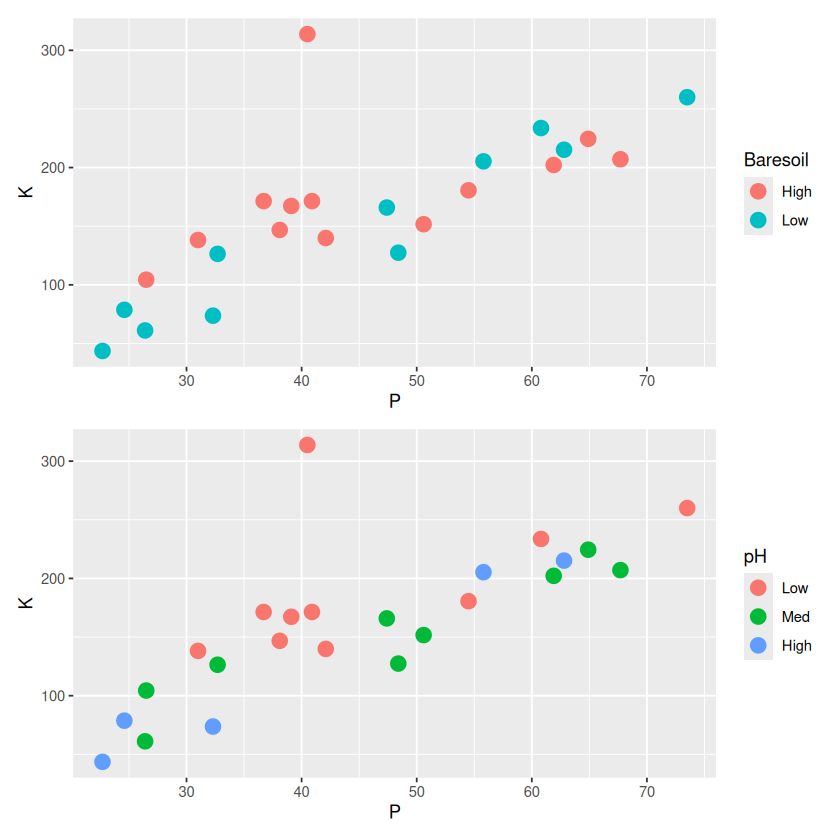

In [340]:
# Comparar a traves de la categoria Baresoil
scatter_by_cat <- function(x, y, category){
    ggplot(data = df_vegetal, aes( x = .data[[x]], y = .data[[y]], color = .data[[category]] )) +
        # geom_point -> scatterplot
        geom_point(size = 4) +
        # Etiquetas del grafico
        labs(x = x, y = y)
}

plot1 <- scatter_by_cat("P", "K", "Baresoil"); plot2 <- scatter_by_cat("P", "K", "pH")
wrap_plots(plot1, plot2, nrow=2)